In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import cm  
from matplotlib.patches import ConnectionPatch
from AES import*
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target
from  numba  import njit, prange

d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [20]:
@njit
def plot_guessing_entropy(preds, real_key, plaintext,trace_num_max,type):

    """
    - preds : the probability for each class (n*256 for a byte, n*9 for Hamming weight)
    - real_key : the key of the target device
    - device_id : id of the target device
    - model_flag : a string for naming GE result
    """
    # GE/SR is averaged over 20 attacks 
    num_averaged = 20
    # max trace num for attack
    guessing_entropy = np.zeros((num_averaged, trace_num_max))
    success_flag = np.zeros((num_averaged, trace_num_max))
    
    # attack multiples times for average
    for time in range(num_averaged):
        # select the attack traces randomly
        random_index_total = list(range(plaintext.shape[0]))
        random_index_total = np.random.permutation(np.arange(plaintext.shape[0]))
        random_index = random_index_total[0:trace_num_max]
        # initialize score matrix
        score_mat = np.zeros((trace_num_max, 256))
        for key_guess in range(0, 256):
            for i in range(0, trace_num_max):
                initialState = plaintext[random_index[i]] ^ key_guess
                #####
                if(type=='SM4'):
                    label =SM4_Sbox[initialState]
                else:
                    label =Skinny_Sbox[initialState]
                score_mat[i, key_guess] = preds[random_index[i], label]

        for i in range(0, trace_num_max):
            log_likelihood = np.sum(score_mat[0:i+1,:], axis=0)
            ranked = np.argsort(log_likelihood)[::-1]
            guessing_entropy[time,i] =  list(ranked).index(real_key)
            if list(ranked).index(real_key) == 0:
                    success_flag[time, i] = 1
 
    guessing_entropy_avg = np.zeros(trace_num_max)
    for i in range(trace_num_max):
        guessing_entropy_avg[i] = np.sum(guessing_entropy[:, i]) / num_averaged

    success_flag = np.sum(success_flag, axis=0)
    success_rate = success_flag/num_averaged 
    return  guessing_entropy_avg,success_rate

<b>Source Model-Target(SM4)

In [8]:
# Main parameter initialization
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/SM4_device1/'
model_path = '../Model/'


In [9]:
prediction_byte=[]
p_total=[]
for byte in range(16):
    # Load profiling traces (template attack dataset)
    profiling_traces, _, _, _, _, _ = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
        byte=byte
    )

    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )

    # Preprocessing pipeline
    # 1. Standardization (zero-mean, unit-variance)
    scaler = preprocessing.StandardScaler()
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack = scaler.transform(X_attack)

    # # 2. Normalization (scale to [0,1] range)
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack = scaler.transform(X_attack)
    X_attack = X_attack.reshape(X_attack.shape)

    # 加载模型并预测
    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D1.h5'
    model.load_weights(model_path + model_name)
    predictions = model.predict(X_attack)
    prediction_byte.append(predictions)
    p_total.append(p_attack)

In [10]:
GE_inf=[]
for byte in range(16):
    key=[0x3F,0x1C,0x77,0xC5,0xA8,0x6E,0x5A,0xF1,0x19,0xA4,0x07,0x3F,0x51,0xFD,0xAE,0xA7]
    real_key=key[byte]
    trace_num_max=5000
    predictions=prediction_byte[byte]
    p_attack=p_total[byte]
    guessing_entropy,success_rate=plot_guessing_entropy(predictions, real_key, p_attack,trace_num_max,'SM4')
    GE_inf.append(guessing_entropy)
# plt.show()

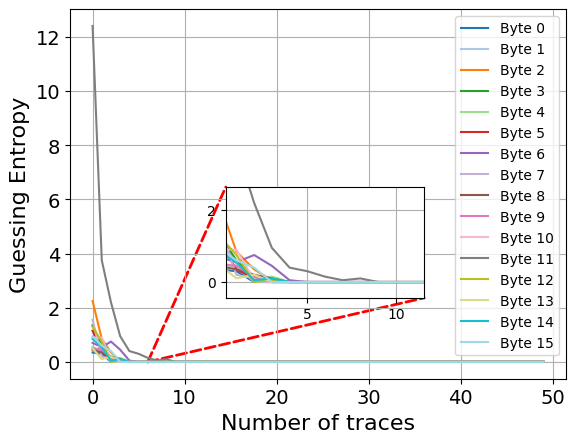

In [13]:
# Visualization parameters setup
sec = 50  # Number of points to display on X-axis
x = np.arange(0, sec)  # Create array for X-axis values
cmap = cm.get_cmap("tab20", 16)  # Get colormap with 16 distinct colors
fig, ax = plt.subplots()  # Create main figure and axes
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '+', '>', '<', '8', 'H', '1', '2','3']  # Marker styles for different bytes

# Plot Guessing Entropy curves for all 16 bytes
for byte in range(16):
    # Plot each byte's GE curve with unique color from colormap
    ax.plot(x, GE_inf[byte][:sec], label=f'Byte {byte}', color=cmap(byte))

# Configure main plot appearance
ax.set_xlabel('Number of traces', fontsize=16)
ax.set_ylabel('Guessing Entropy', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=10)  # Display legend with byte labels

# Create inset axes for zoomed-in view
axins = inset_axes(ax, width="40%", height="30%", loc="lower left",
                   bbox_to_anchor=(0.3, 0.2, 1, 1), bbox_transform=ax.transAxes)

# Plot zoomed-in view of GE curves
for byte in range(16):
    axins.plot(x, GE_inf[byte][:sec], color=cmap(byte))

# Define zoom region (X-axis range 2-10)
zone_left = 2
zone_right = 10

# Calculate dynamic axis limits for inset plot
x_ratio = 0.2  # X-axis expansion ratio
y_ratio = 0.2  # Y-axis expansion ratio

# X-axis limits with expansion buffer
xlim0 = x[zone_left] - (x[zone_right] - x[zone_left]) * x_ratio
xlim1 = x[zone_right] + (x[zone_right] - x[zone_left]) * x_ratio

# Y-axis limits based on data range in zoom region
y = np.hstack([GE_inf[byte][zone_left:zone_right] for byte in range(16)])
ylim0 = np.min(y) - (np.max(y) - np.min(y)) * y_ratio
ylim1 = np.max(y) + (np.max(y) - np.min(y)) * y_ratio

# Apply calculated limits to inset plot
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)

# Create connection lines between main plot and inset
x_main = 6  # Reference X-position for connection lines
y_main = GE_inf[0][x_main]  # Y-value at reference position

# Get inset plot boundary coordinates
x_inset_left = axins.get_xlim()[0]
y_inset_top = axins.get_ylim()[1]
x_inset_right = axins.get_xlim()[1]
y_inset_bottom = axins.get_ylim()[0]

# Create dashed connection lines
line1 = ConnectionPatch(xyA=(x_main, y_main), xyB=(x_inset_left, y_inset_top),
                        coordsA='data', coordsB='data', axesA=ax, axesB=axins,
                        color='red', linestyle='--', linewidth=2)

line2 = ConnectionPatch(xyA=(x_main, y_main), xyB=(x_inset_right, y_inset_bottom),
                        coordsA='data', coordsB='data', axesA=ax, axesB=axins,
                        color='red', linestyle='--', linewidth=2)

# Add connection lines to main plot
ax.add_artist(line1)
ax.add_artist(line2)

# Final plot formatting and saving
ax.grid(True)
plt.grid(True)
plt.savefig('GE_16_SM4.png')  # Save visualization to file
plt.show()  # Display interactive plot

<b>Source Model-Target(Skinny)

In [21]:
# Main parameter initialization
profiling_Data_path='../Dataset/AES_device1/'
Target_Data_path='../Dataset/Skinny_device1/'
model_path = '../Model/'

In [22]:
prediction_byte=[]
p_total=[]
for byte in range(16):
    # Load profiling traces (template attack dataset)
    profiling_traces, _, _, _, _, _ = load_CW_Source(
        in_file=profiling_Data_path,
        sec=18000,  # Fixed security parameter from original implementation
        byte=byte
    )

    # Load target device data
    X_attack, label_V, p_attack = load_CW_Target(
        in_file=Target_Data_path,
        byte=byte
    )

    # Preprocessing pipeline
    # 1. Standardization (zero-mean, unit-variance)
    scaler = preprocessing.StandardScaler()
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack = scaler.transform(X_attack)

    # # 2. Normalization (scale to [0,1] range)
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack = scaler.transform(X_attack)
    X_attack = X_attack.reshape(X_attack.shape)

    model = cnn_classifier(input_size=800)
    model_name = f'Source_Model_byte{byte}_D1.h5'
    model.load_weights(model_path + model_name)
    predictions = model.predict(X_attack)
    prediction_byte.append(predictions)
    p_total.append(p_attack)

In [23]:
GE_inf=[]
for byte in range(16):
    key=[0x3F,0x1C,0x77,0xC5,0xA8,0x6E,0x5A,0xF1,0x19,0xA4,0x07,0x3F,0x51,0xFD,0xAE,0xA7]
    real_key=key[byte]
    trace_num_max=5000
    predictions=prediction_byte[byte]
    p_attack=p_total[byte]
    guessing_entropy,success_rate=plot_guessing_entropy(predictions, real_key, p_attack,trace_num_max,'Skinny')
    GE_inf.append(guessing_entropy)
# plt.show()

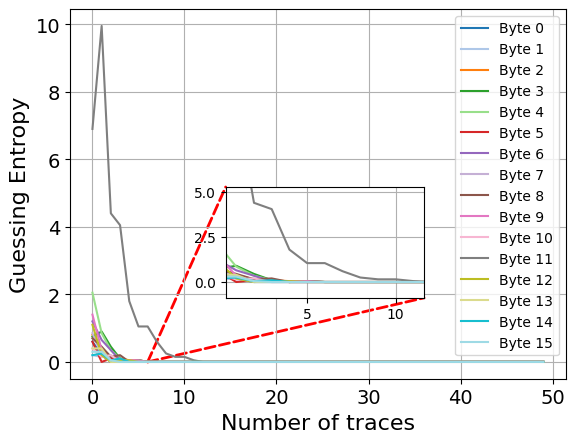

In [24]:
# Visualization parameters setup
sec = 50  # Number of data points to display on X-axis
x = np.arange(0, sec)  # Create array for X-axis values
cmap = cm.get_cmap("tab20", 16)  # Get colormap with 16 distinct colors
fig, ax = plt.subplots()  # Create main figure and axes
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', '+', '>', '<', '8', 'H', '1', '2','3']  # Marker styles for different bytes

# Plot Guessing Entropy curves for all 16 bytes using validation set results
for byte in range(16):
    # Validation data (GE_inf) is used here - no gradient updates involved
    ax.plot(x, GE_inf[byte][:sec], label=f'Byte {byte}', color=cmap(byte))

# Configure main plot appearance
ax.set_xlabel('Number of traces', fontsize=16)
ax.set_ylabel('Guessing Entropy', fontsize=16)
ax.tick_params(labelsize=14)
ax.legend(fontsize=10)  # Legend shows validation results per byte

# Create inset axes for detailed view of early convergence
axins = inset_axes(ax, width="40%", height="30%", loc="lower left",
                   bbox_to_anchor=(0.3, 0.2, 1, 1), bbox_transform=ax.transAxes)

# Plot zoomed view of validation results (2-10 traces range)
for byte in range(16):
    axins.plot(x, GE_inf[byte][:sec], color=cmap(byte))

# Define analysis window for detailed view
zone_left = 2  # Start of region of interest
zone_right = 10  # End of region of interest

# Calculate dynamic axis limits with buffer zones
x_ratio = 0.2  # X-axis expansion factor
y_ratio = 0.2  # Y-axis expansion factor

# Set X-axis limits with buffer
xlim0 = x[zone_left] - (x[zone_right] - x[zone_left]) * x_ratio
xlim1 = x[zone_right] + (x[zone_right] - x[zone_left]) * x_ratio

# Calculate Y-axis limits based on validation data range
y = np.hstack([GE_inf[byte][zone_left:zone_right] for byte in range(16)])
ylim0 = np.min(y) - (np.max(y) - np.min(y)) * y_ratio
ylim1 = np.max(y) + (np.max(y) - np.min(y)) * y_ratio

# Apply calculated limits to inset plot
axins.set_xlim(xlim0, xlim1)
axins.set_ylim(ylim0, ylim1)

# Create visual connection between main plot and inset
x_main = 6  # Reference X-position in main plot
y_main = GE_inf[0][x_main]  # Y-value from validation data

# Get inset plot boundary coordinates
x_inset_left = axins.get_xlim()[0]
y_inset_top = axins.get_ylim()[1]
x_inset_right = axins.get_xlim()[1]
y_inset_bottom = axins.get_ylim()[0]

# Create dashed connection lines (visual guides only)
line1 = ConnectionPatch(xyA=(x_main, y_main), xyB=(x_inset_left, y_inset_top),
                        coordsA='data', coordsB='data', axesA=ax, axesB=axins,
                        color='red', linestyle='--', linewidth=2)

line2 = ConnectionPatch(xyA=(x_main, y_main), xyB=(x_inset_right, y_inset_bottom),
                        coordsA='data', coordsB='data', axesA=ax, axesB=axins,
                        color='red', linestyle='--', linewidth=2)

# Add connection elements to plot
ax.add_artist(line1)
ax.add_artist(line2)

# Final rendering and output
ax.grid(True)
plt.grid(True)
# Save visualization of validation results
plt.savefig('GE_16_Skinny.pdf')  # Vector format
plt.savefig('GE_16_Skinny.png')  # Raster format
plt.show()  # Display interactive plot